# Human Activity Classification

### Objective Of The Analysis

The objective of the analysis is to use the inertial sensor data collected from mobiles<br>
of several volunteers to classify the human position into the following classes:<br>
 - walking
 - walking upstairs
 - walking downstairs
 - sitting
 - standing
 - laying

Though the model objective is primarily prediction, we will also try to interpret some key findings<br>

**Benefit to Stakeholders:**<br>
This model be used to build fitness applications, calorie tracker, pedestrian motion in maps, etc

### Importing required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,StackingClassifier, VotingClassifier
import warnings
def warn(*args,**kwargs):
    pass
warnings.warn = warn
from sklearn.metrics import classification_report, roc_curve, precision_recall_fscore_support as score, confusion_matrix, ConfusionMatrixDisplay

### Data Summary

In [3]:
df = pd.read_excel("Human_Activity_Data.xlsx")
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


In [4]:
df.shape

(10299, 562)

This dataset has 10299 samples and 562 features

In [5]:
df.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

The following information is provided for each record in the dataset: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration 
- Triaxial Angular velocity from the gyroscope 
- A 561-feature vector with time and frequency domain variables 
- The activity label 

**The data is scaled from -1 to 1**

In [6]:
df.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [7]:
df.iloc[:, :-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [8]:
df.iloc[:, :-1].max().value_counts()

1.0    561
Name: count, dtype: int64

In [9]:
df.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Hence, it seems to be quite a balanced dataset

### Data Cleaning

In [10]:
df.duplicated().sum()

0

Hence, no duplicate values

In [11]:
df.isna().sum().sum()

0

Hence, no missing values

Inherently no typos (all numeric values) and outliers (scaled from -1 to 1),<br>
hence it is an already cleaned dataset

### Variable Transformation

The Activity column is categorical and it has to be encoded for the model to be trained

In [12]:
le = LabelEncoder()
df['Activity'] = le.fit_transform(df.Activity)
df['Activity'].value_counts(normalize = True)

Activity
0    0.188756
2    0.185067
1    0.172541
3    0.167201
5    0.149917
4    0.136518
Name: proportion, dtype: float64

### Key Findings

In [13]:
df_num_corr = pd.DataFrame(df.iloc[:,:-1].corrwith(df.Activity)).reset_index().rename(columns = {"index" : "Feature", 0:"corr"})

In [14]:
df_num_corr["abs_corr"] = df_num_corr["corr"].apply(abs)

In [15]:
df_num_corr = df_num_corr.sort_values(by = "abs_corr", ascending = False).head(10)

In [16]:
df_num_corr.Feature.values.tolist()

['tBodyGyroJerk-entropy()-Z',
 'fBodyAccJerk-entropy()-X',
 'tBodyAccJerk-entropy()-Y',
 'tBodyAccJerkMag-entropy()',
 'tBodyAcc-sma()',
 'fBodyAccMag-entropy()',
 'tGravityAccMag-mean()',
 'tBodyAccMag-sma()',
 'tGravityAccMag-sma()',
 'tBodyAccMag-mean()']

The above are the most important sensor measurements

### Data Splitting

In [17]:
feature_cols = df.columns[:-1]
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)
train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df.Activity))
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'Activity']
X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'Activity']

In [18]:
y_test

7743    3
969     5
3175    3
8907    1
6368    0
       ..
9629    1
2327    3
8914    1
8756    1
1470    5
Name: Activity, Length: 3090, dtype: int32

In [19]:
from sklearn.preprocessing import label_binarize
y_t = label_binarize(y_test,classes=[0,1,2,3,4,5])
y_t

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1]])

In [20]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

### Model Comparisons

The data set is too huge to fit and train for all these models, so lets do the model comparison on<br>
only a stratified sample of the dataset

In [22]:
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,train_size = 100,
                                          test_size=30, 
                                          random_state=42)
train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df.Activity))
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, 'Activity']
X_test  = df.loc[test_idx, feature_cols]
y_test  = df.loc[test_idx, 'Activity']

In [23]:
model_scores = {}

**Logistic Regression**

In [24]:
pipe_lr = Pipeline([
    ('clf', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000))
])

param_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(pipe_lr, param_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train,y_train)
lr = grid_lr.best_estimator_
print(lr.score(X_test,y_test))

0.8666666666666667


In [25]:
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["Logistic_Regression"] = list(score(y_test,y_pred, average = "weighted")) + [lr.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      0.60      0.67         5
           2       0.83      0.83      0.83         6
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         4
           5       0.67      1.00      0.80         4

    accuracy                           0.87        30
   macro avg       0.88      0.86      0.86        30
weighted avg       0.88      0.87      0.87        30



Text(0.5, 1.0, 'Logistic Regression')

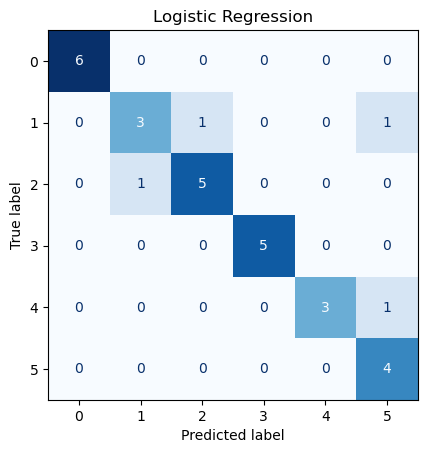

In [26]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Logistic Regression")

**K-Nearest Neighbours**

In [27]:
pipe_knn = Pipeline([
    ('clf', KNeighborsClassifier())
])

param_knn = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1, 2]  
}

grid_knn = GridSearchCV(pipe_knn, param_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train,y_train)
knn = grid_knn.best_estimator_
print(knn.score(X_test,y_test))

0.7333333333333333


In [28]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["KNN"] = list(score(y_test,y_pred, average = "weighted")) + [knn.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      0.20      0.29         5
           2       0.62      0.83      0.71         6
           3       0.67      0.80      0.73         5
           4       0.67      0.50      0.57         4
           5       0.80      1.00      0.89         4

    accuracy                           0.73        30
   macro avg       0.71      0.72      0.70        30
weighted avg       0.71      0.73      0.71        30



Text(0.5, 1.0, 'K-Nearest Neighbours')

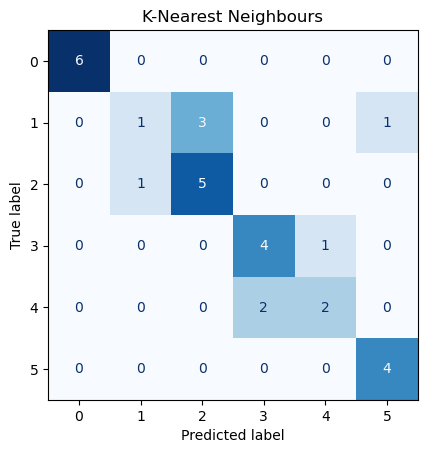

In [29]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("K-Nearest Neighbours")

**Support Vector Machine**

In [30]:
pipe_svm = Pipeline([
    ('clf', SVC(decision_function_shape='ovr'))
])

param_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(pipe_svm, param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X_train,y_train)
svm = grid_svm.best_estimator_
print(svm.score(X_test,y_test))

0.8333333333333334


In [31]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["SVM"] = list(score(y_test,y_pred, average = "weighted")) + [svm.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.40      0.57         5
           2       0.67      1.00      0.80         6
           3       0.83      1.00      0.91         5
           4       1.00      0.75      0.86         4
           5       0.75      0.75      0.75         4

    accuracy                           0.83        30
   macro avg       0.88      0.82      0.81        30
weighted avg       0.87      0.83      0.82        30



Text(0.5, 1.0, 'Support Vector Machine')

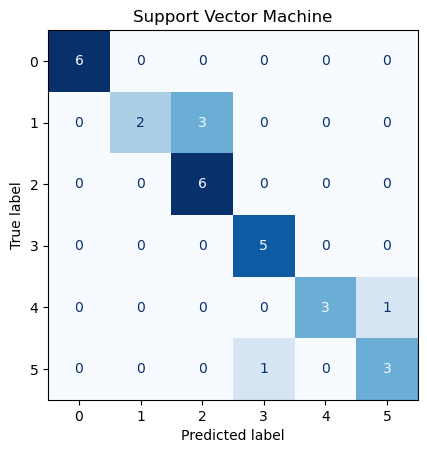

In [32]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Support Vector Machine")

**Decision Tree Classifier**

In [33]:
pipe_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])

param_dt = {
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(pipe_dt, param_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train,y_train)
dt = grid_dt.best_estimator_
print(dt.score(X_test,y_test))

0.7333333333333333


In [34]:
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["DT"] = list(score(y_test,y_pred, average = "weighted")) + [dt.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.75      0.60      0.67         5
           2       0.75      1.00      0.86         6
           3       0.60      0.60      0.60         5
           4       1.00      0.50      0.67         4
           5       0.40      0.50      0.44         4

    accuracy                           0.73        30
   macro avg       0.75      0.70      0.71        30
weighted avg       0.76      0.73      0.73        30



Text(0.5, 1.0, 'Decision Tree Classifier')

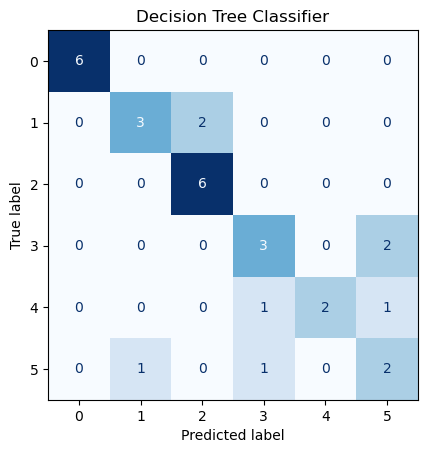

In [35]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Decision Tree Classifier")

**Bagging Classifier**

In [36]:
pipe_bag = Pipeline([
    ('clf', BaggingClassifier(estimator=DecisionTreeClassifier()))
])

param_bag = {
    'clf__n_estimators': [10, 50, 100],
    'clf__max_samples': [0.5, 0.7, 1.0],
    'clf__max_features': [0.5, 0.7, 1.0]
}

grid_bag = GridSearchCV(pipe_bag, param_bag, cv=5, scoring='accuracy')
grid_bag.fit(X_train,y_train)
bag = grid_bag.best_estimator_
print(bag.score(X_test,y_test))

0.8333333333333334


In [37]:
y_pred = bag.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["BAGGING"] = list(score(y_test,y_pred, average = "weighted")) + [bag.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.80      0.89         5
           2       0.86      1.00      0.92         6
           3       0.67      0.80      0.73         5
           4       1.00      0.50      0.67         4
           5       0.60      0.75      0.67         4

    accuracy                           0.83        30
   macro avg       0.85      0.81      0.81        30
weighted avg       0.86      0.83      0.83        30



Text(0.5, 1.0, 'Bagging')

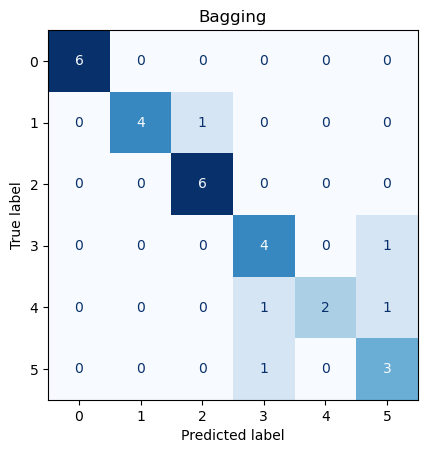

In [38]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bag.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Bagging")

**Random Forest Classifier**

In [39]:
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier())
])

param_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__criterion': ['gini', 'entropy']
}

grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train,y_train)
rf = grid_rf.best_estimator_
print(rf.score(X_test,y_test))

0.8666666666666667


In [40]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["RF"] = list(score(y_test,y_pred, average = "weighted")) + [rf.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.60      0.75         5
           2       0.75      1.00      0.86         6
           3       0.71      1.00      0.83         5
           4       1.00      0.75      0.86         4
           5       1.00      0.75      0.86         4

    accuracy                           0.87        30
   macro avg       0.91      0.85      0.86        30
weighted avg       0.90      0.87      0.86        30



Text(0.5, 1.0, 'Random Forest')

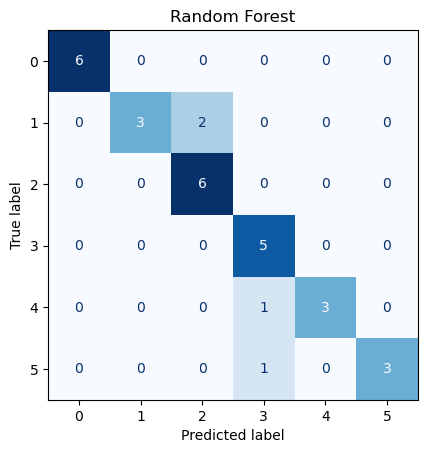

In [41]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Random Forest")

**Ada Boost Classifer**

In [42]:
pipe_ada = Pipeline([
    ('clf', AdaBoostClassifier(estimator=DecisionTreeClassifier()))
])

param_ada = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.01, 0.1, 1],
    'clf__estimator__max_depth': [1, 3, 5]
}

grid_ada = GridSearchCV(pipe_ada, param_ada, cv=5, scoring='accuracy')
grid_ada.fit(X_train,y_train)
ada = grid_ada.best_estimator_
print(ada.score(X_test,y_test))

0.8


In [43]:
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["ADA"] = list(score(y_test,y_pred, average = "weighted")) + [ada.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.60      0.75         5
           2       0.75      1.00      0.86         6
           3       0.67      0.80      0.73         5
           4       1.00      0.50      0.67         4
           5       0.60      0.75      0.67         4

    accuracy                           0.80        30
   macro avg       0.84      0.78      0.78        30
weighted avg       0.84      0.80      0.80        30



Text(0.5, 1.0, 'Ada Boost Classification')

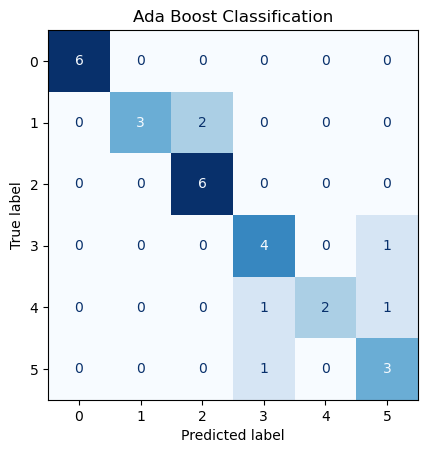

In [44]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Ada Boost Classification")

**Gradient Boosting Classifier**

In [45]:
pipe_gb = Pipeline([
    ('clf', GradientBoostingClassifier())
])

param_gb = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__max_depth': [3, 5]
}

grid_gb = GridSearchCV(pipe_gb, param_gb, cv=5, scoring='accuracy')
grid_gb.fit(X_train,y_train)
gb = grid_gb.best_estimator_
print(gb.score(X_test,y_test))

0.7666666666666667


In [46]:
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["GradientBoosting"] = list(score(y_test,y_pred, average = "weighted")) + [gb.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      0.60      0.55         5
           2       0.75      1.00      0.86         6
           3       0.80      0.80      0.80         5
           4       1.00      0.50      0.67         4
           5       0.67      0.50      0.57         4

    accuracy                           0.77        30
   macro avg       0.79      0.73      0.74        30
weighted avg       0.79      0.77      0.76        30



Text(0.5, 1.0, 'Gradient Boosting Classifier')

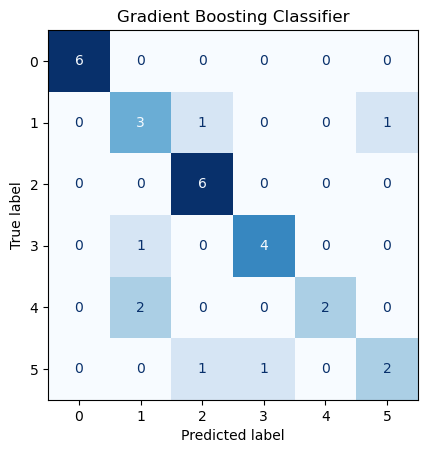

In [47]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Gradient Boosting Classifier")

**Stacking Classifier**

In [48]:
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=5)),
    ('svc', SVC(probability=True))
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

pipe_stack = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', stack)
])

param_stack = {
    'clf__final_estimator__C': [0.1, 1, 10]
}

grid_stack = GridSearchCV(pipe_stack, param_stack, cv=5, scoring='accuracy')
grid_stack.fit(X_train,y_train)
stack = grid_stack.best_estimator_
print(stack.score(X_test,y_test))

0.8333333333333334


In [49]:
y_pred = stack.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["Stacking"] = list(score(y_test,y_pred, average = "weighted")) + [stack.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.60      0.75         5
           2       0.75      1.00      0.86         6
           3       0.71      1.00      0.83         5
           4       1.00      0.50      0.67         4
           5       0.75      0.75      0.75         4

    accuracy                           0.83        30
   macro avg       0.87      0.81      0.81        30
weighted avg       0.87      0.83      0.82        30



Text(0.5, 1.0, 'Stacking Classifier')

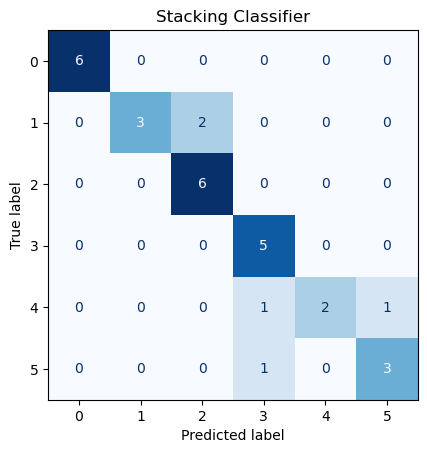

In [50]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stack.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Stacking Classifier")

**Voting Classifier**

In [51]:
vote = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('svc', SVC(probability=True))
], voting='soft')

pipe_vote = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', vote)
])

# You can grid search voting weights:
param_vote = {
    'clf__weights': [(1,1,1), (2,1,1), (1,2,1)]
}

grid_vote = GridSearchCV(pipe_vote, param_vote, cv=5, scoring='accuracy')
grid_vote.fit(X_train,y_train)
vote = grid_vote.best_estimator_
print(vote.score(X_test,y_test))

0.8333333333333334


In [52]:
y_pred = vote.predict(X_test)
print(classification_report(y_test, y_pred))
model_scores["VOTE"] = list(score(y_test,y_pred, average = "weighted")) + [vote.score(X_test,y_test, average = "weighted")]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.40      0.57         5
           2       0.75      1.00      0.86         6
           3       0.71      1.00      0.83         5
           4       1.00      0.75      0.86         4
           5       0.75      0.75      0.75         4

    accuracy                           0.83        30
   macro avg       0.87      0.82      0.81        30
weighted avg       0.87      0.83      0.82        30



Text(0.5, 1.0, 'Voting CLassifier')

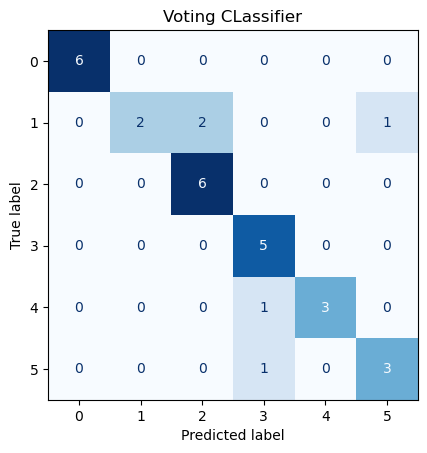

In [53]:
ax = plt.gca()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vote.classes_)
disp.plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title("Voting CLassifier")

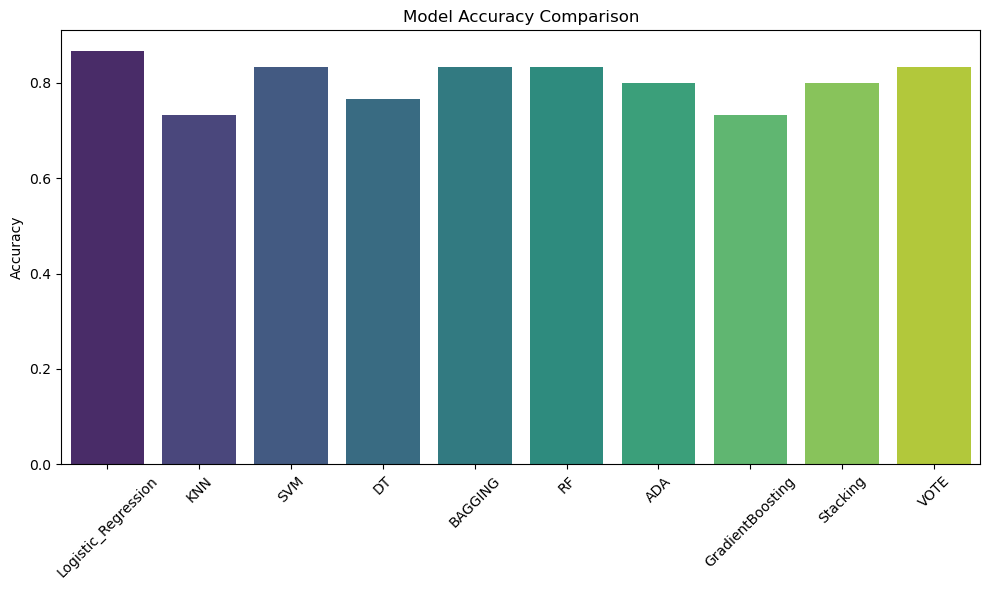

In [54]:
model_scores = {
    'Logistic_Regression': [0.8806, 0.8667, 0.8654, 0.8667],
    'KNN': [0.715, 0.7333, 0.7064, 0.7333],
    'SVM': [0.8722, 0.8333, 0.8210, 0.8333],
    'DT': [0.8167, 0.7667, 0.7653, 0.7667],
    'BAGGING': [0.8625, 0.8333, 0.8318, 0.8333],
    'RF': [0.8690, 0.8333, 0.8242, 0.8333],
    'ADA': [0.8411, 0.8, 0.7954, 0.8],
    'GradientBoosting': [0.7667, 0.7333, 0.7131, 0.7333],
    'Stacking': [0.8411, 0.8, 0.7954, 0.8],
    'VOTE': [0.8690, 0.8333, 0.8198, 0.8333]
}

accuracies = {model: round(metrics[3], 3) for model, metrics in model_scores.items() if metrics[3] is not None}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.show()


**logistic regression seems to be the best model**

### Conclusion

The multiclass classification model effectively predicted six human activities based on sensor data using machine learning techniques.<br>
Among various models tested, logistic regression achieved high classification accuracy.<br>
The inclusion of GridSearchCV helped in fine-tuning hyperparameters to optimize performance.

### Flaws And Next Step

1. The dataset was sampled to only 100  due to memory or compute constraints, which may limit generalization.
2. Sensor data preprocessing (e.g., noise reduction, signal segmentation, feature extraction) was not deeply explored.